In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


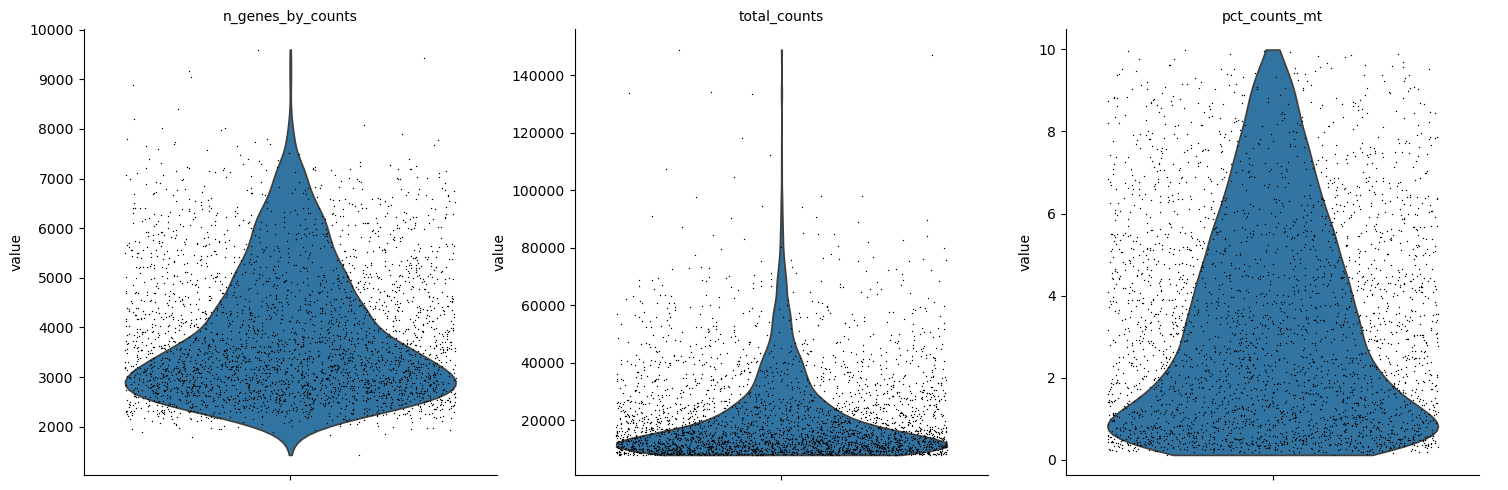

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


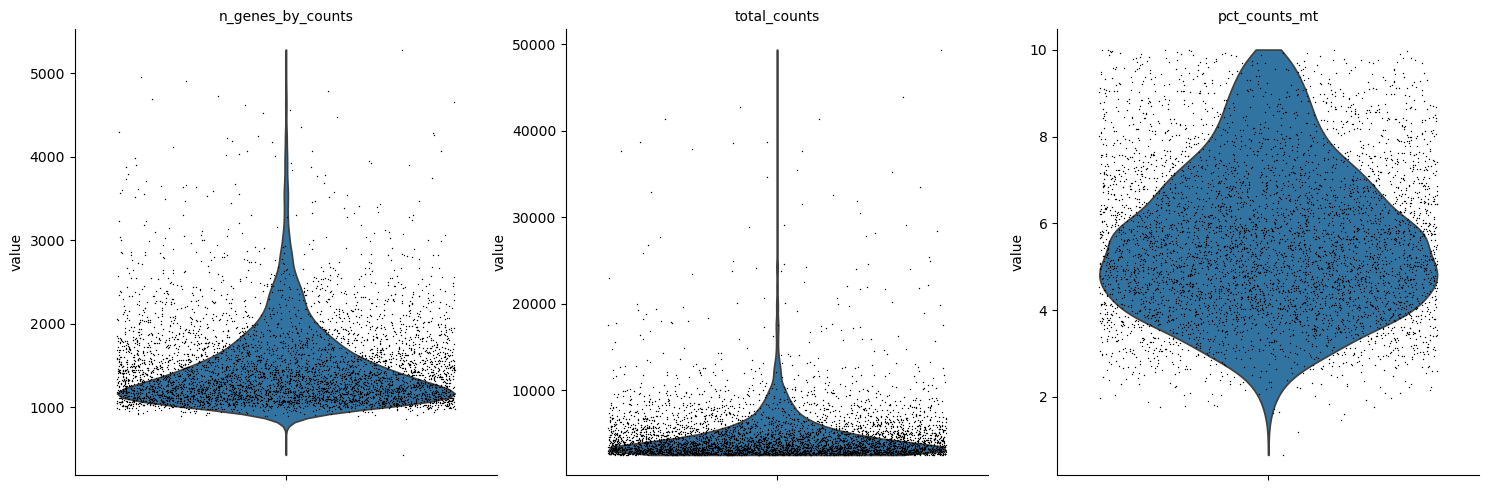

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


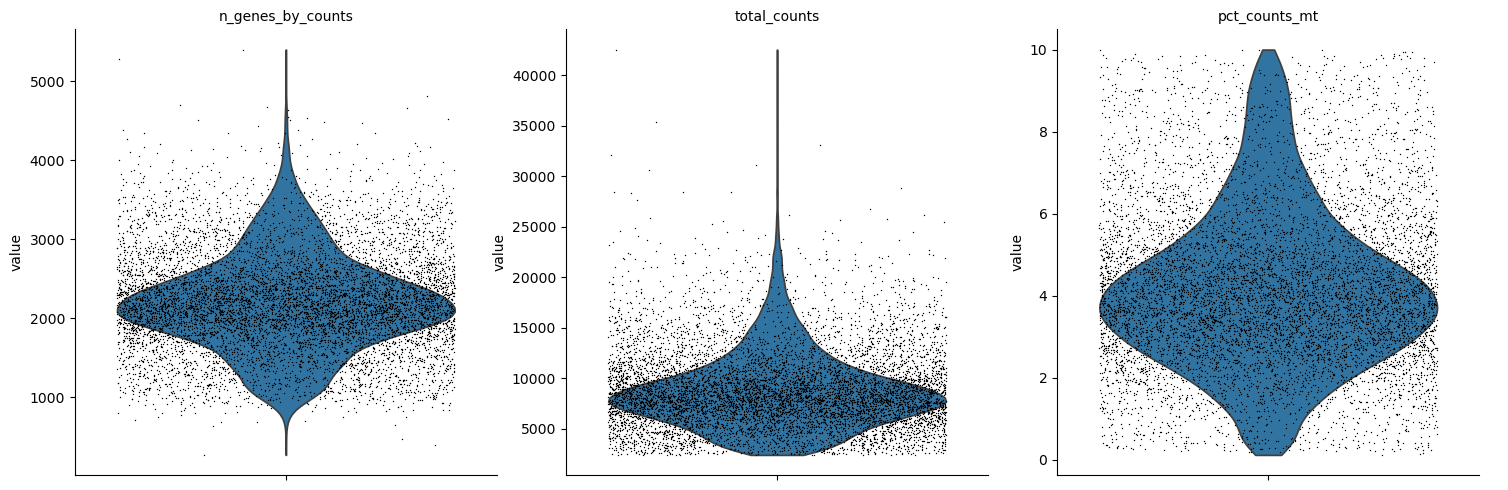

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


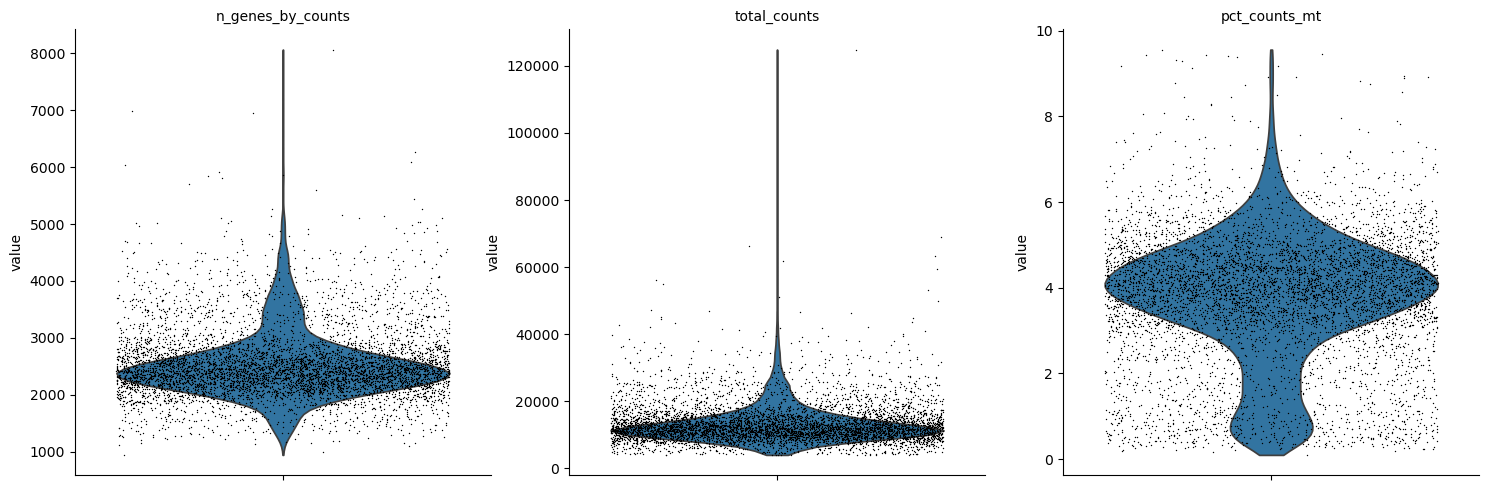

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


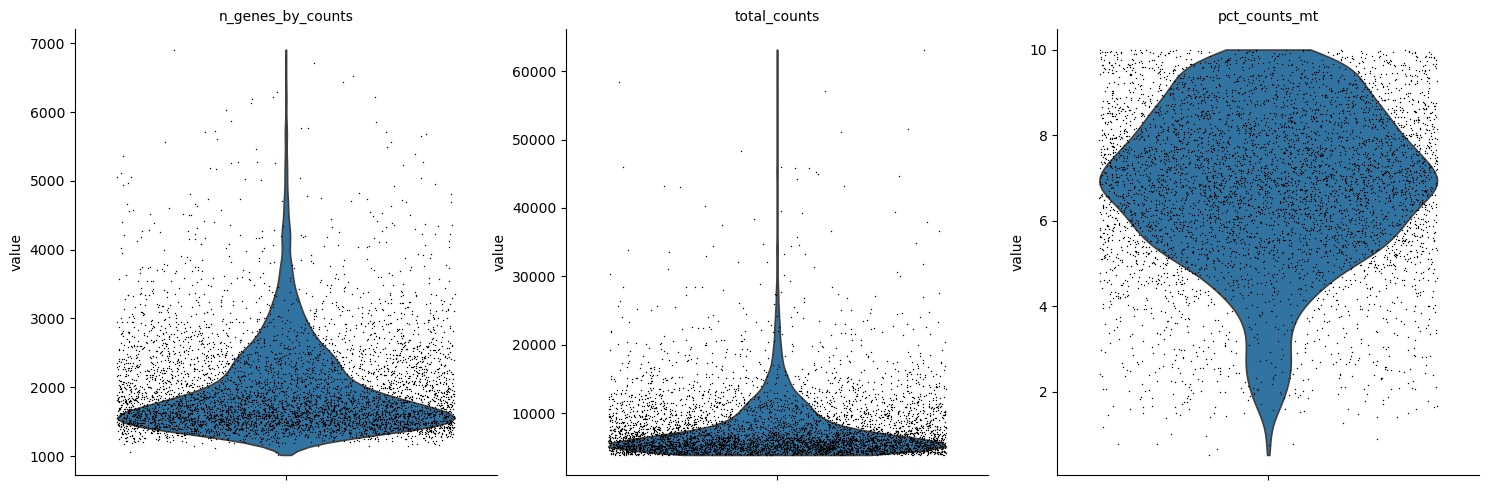

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_1043649/1379501109.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')

In [11]:
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]

In [15]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'G

In [13]:
adata_non_immune.raw = adata_non_immune  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_non_immune,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="source",
    subset=True,
)

In [14]:
import scvi
scvi.model.SCVI.setup_anndata(adata_non_immune, layer="counts", batch_key="source")

In [16]:
model = scvi.model.SCVI(adata_non_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [17]:
model.train()

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/287 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=287` reached.


In [18]:
SCVI_LATENT_KEY = "X_scVI"
adata_non_immune.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [19]:
sc.pp.neighbors(adata_non_immune, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_non_immune,resolution=0.5)

/tmp/ipykernel_1043649/1145043127.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_non_immune,resolution=0.5)


In [21]:
adata_non_immune.write(os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT','blca_nm_OUTPUT_non_immune_scvi.h5ad'), compression="gzip")

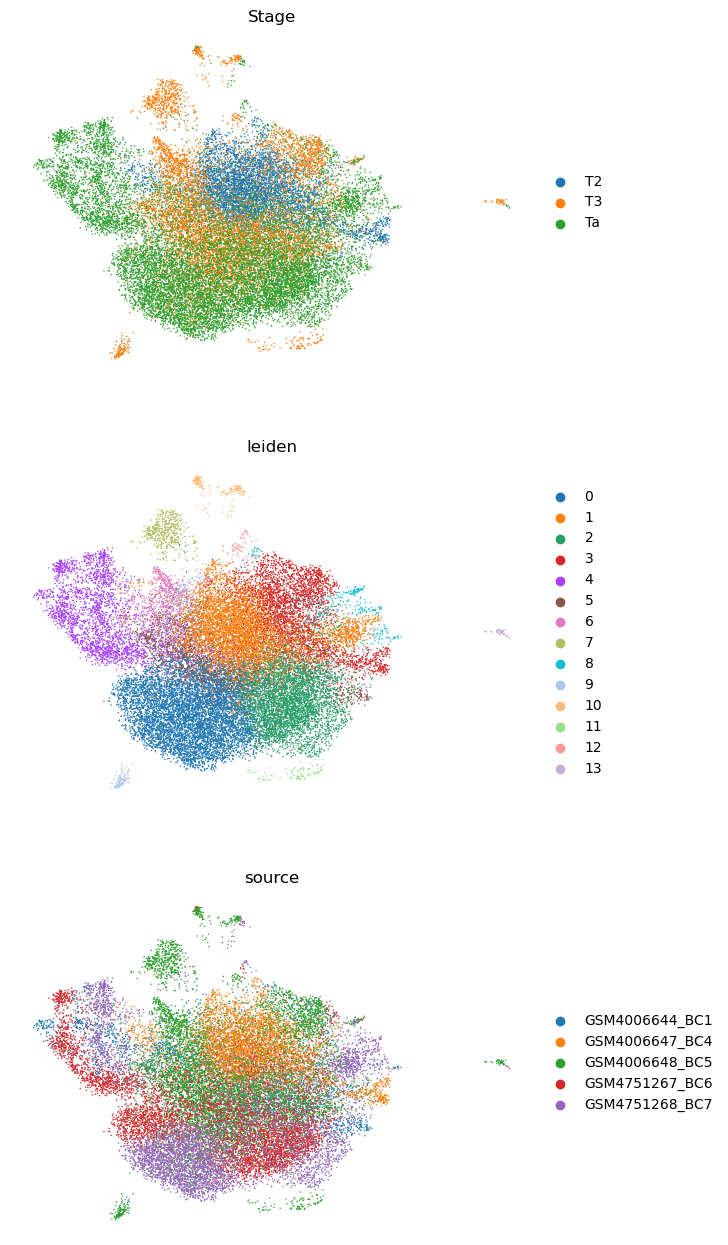

In [118]:
#sc.tl.umap(adata_non_immune)#, min_dist=0.5)
sc.pl.umap(
    adata_non_immune,
    color=[ 'Stage',"leiden","source",],
    frameon=False,
    ncols=1,
)

In [39]:
adata_non_immune.obs['Stage'] = 'Ta'
adata_non_immune.obs.loc[adata_non_immune.obs['source'] == 'GSM4006647_BC4', 'Stage'] = 'T2'
adata_non_immune.obs.loc[adata_non_immune.obs['source'] == 'GSM4006648_BC5', 'Stage'] = 'T3'

In [38]:
set(adata_non_immune.obs['source'])

{'GSM4006644_BC1',
 'GSM4006647_BC4',
 'GSM4006648_BC5',
 'GSM4751267_BC6',
 'GSM4751268_BC7'}

In [27]:
adata_non_immune.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,Status,Stage
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5,Ta,NaN
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2,Ta,NaN
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2,Ta,NaN
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4,Ta,NaN
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1,Ta,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0,Ta,NaN
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0,Ta,NaN
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2,Ta,NaN
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1,Ta,NaN


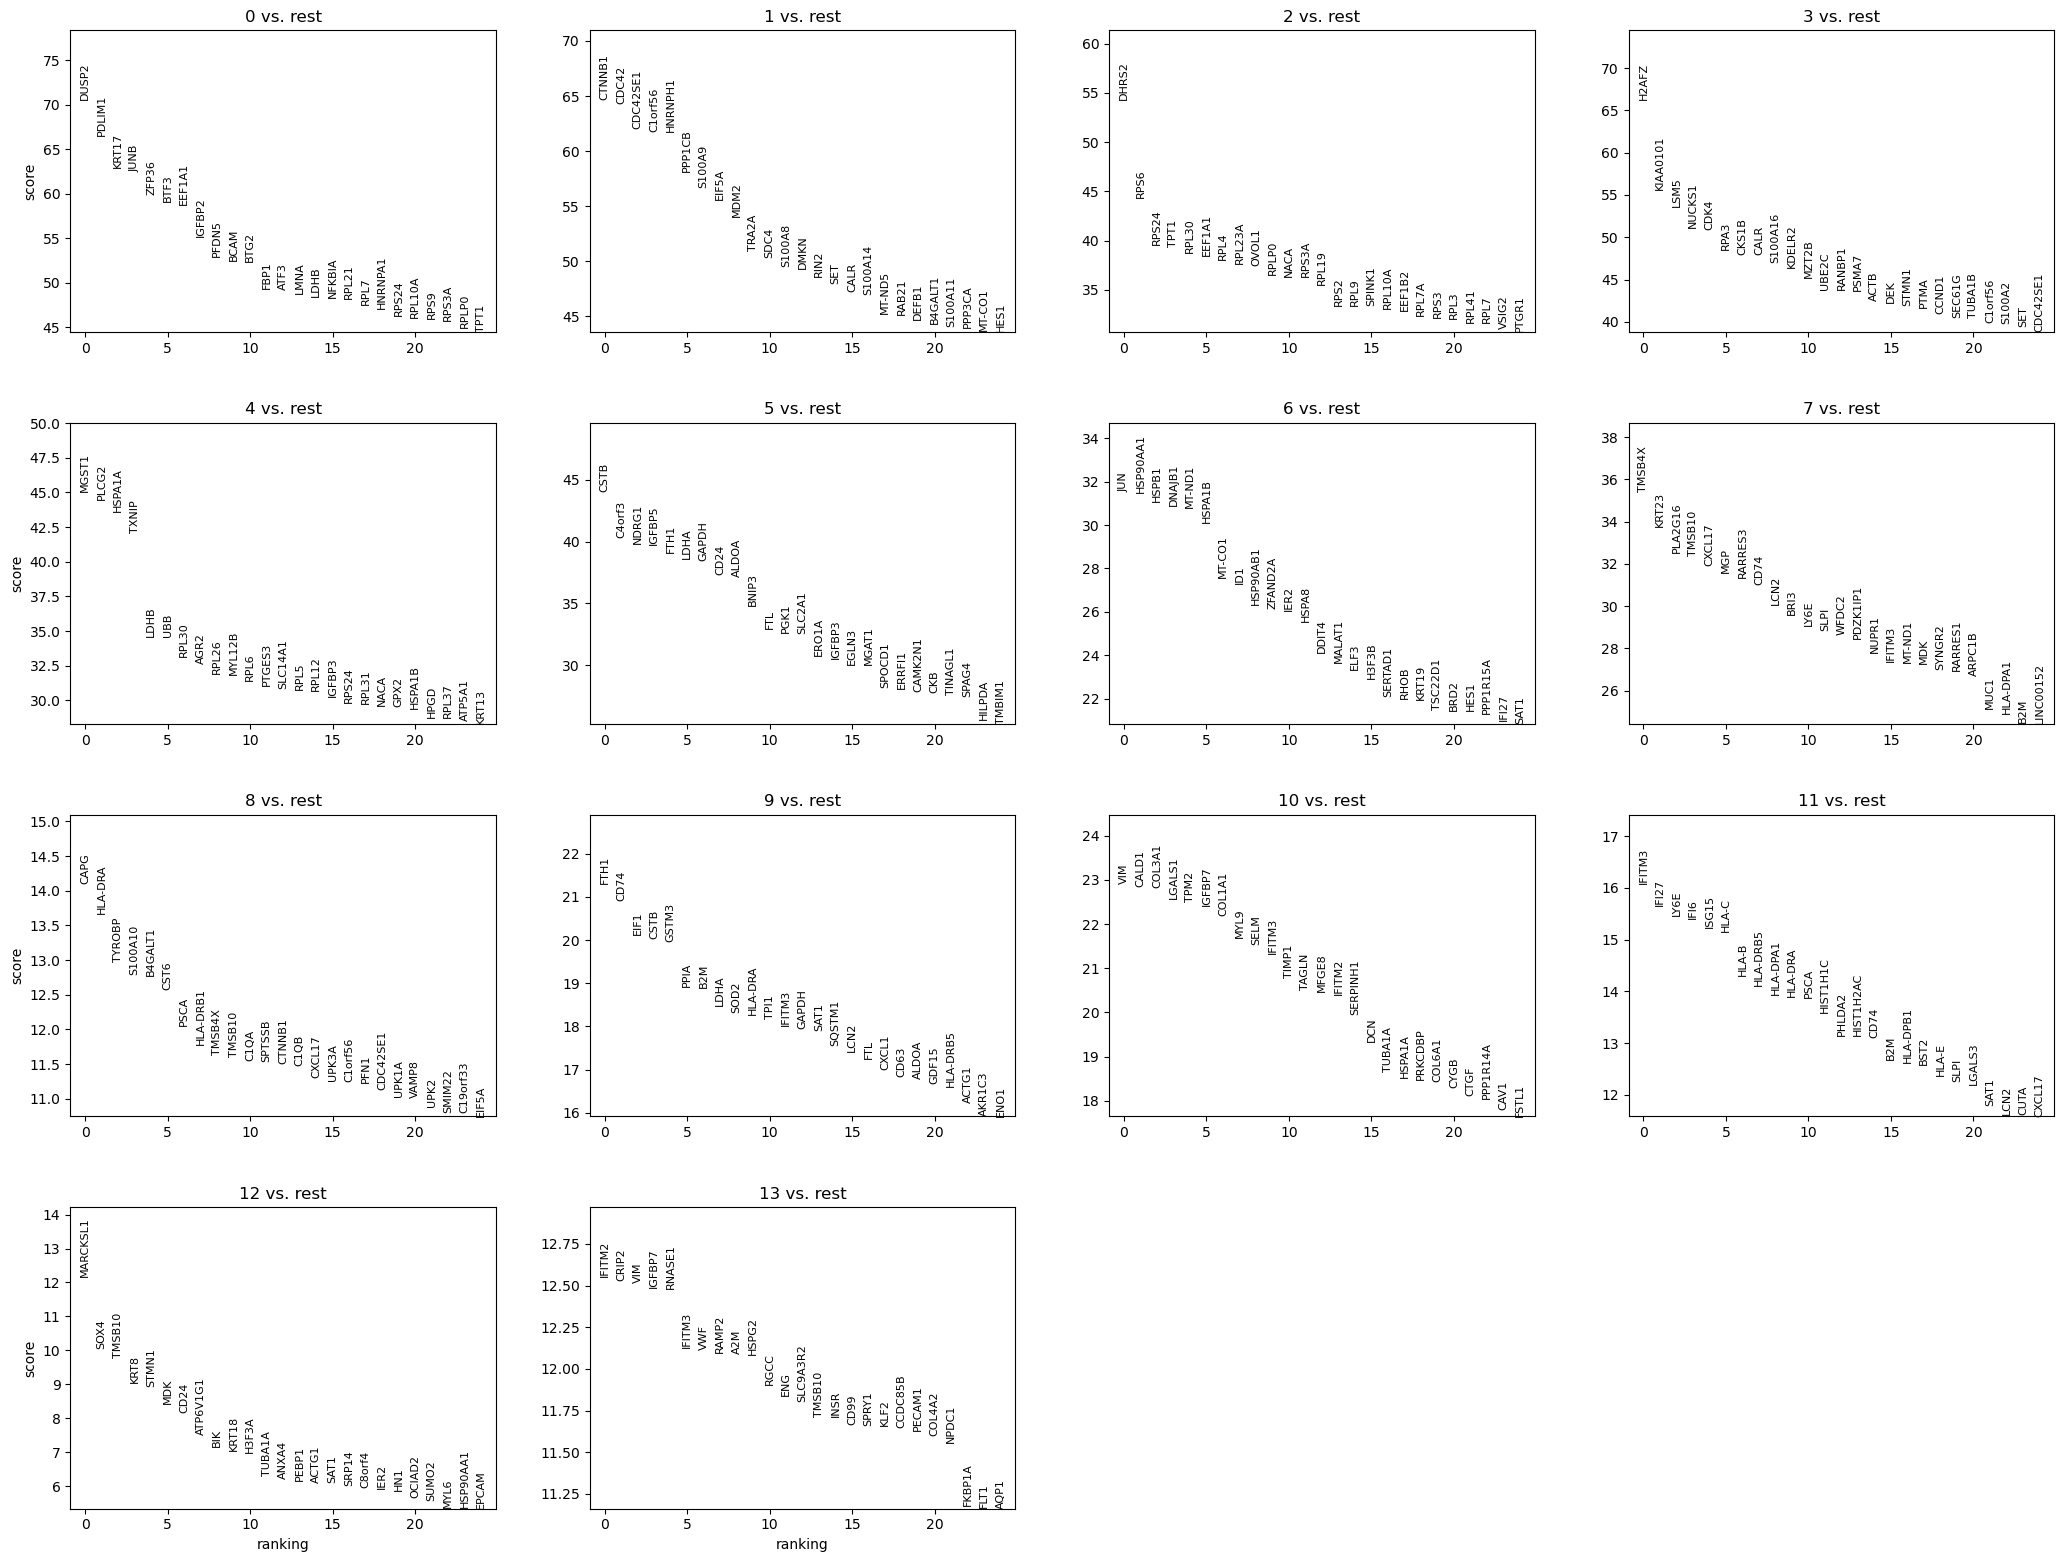

In [28]:
sc.tl.rank_genes_groups(adata_non_immune, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_non_immune, n_genes=25, sharey=False)

In [32]:
pd.DataFrame(adata_non_immune.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,DUSP2,CTNNB1,DHRS2,H2AFZ,MGST1,CSTB,JUN,TMSB4X,CAPG,FTH1,VIM,IFITM3,MARCKSL1,IFITM2
1,PDLIM1,CDC42,RPS6,KIAA0101,PLCG2,C4orf3,HSP90AA1,KRT23,HLA-DRA,CD74,CALD1,IFI27,SOX4,CRIP2
2,KRT17,CDC42SE1,RPS24,LSM5,HSPA1A,NDRG1,HSPB1,PLA2G16,TYROBP,EIF1,COL3A1,LY6E,TMSB10,VIM
3,JUNB,C1orf56,TPT1,NUCKS1,TXNIP,IGFBP5,DNAJB1,TMSB10,S100A10,CSTB,LGALS1,IFI6,KRT8,IGFBP7
4,ZFP36,HNRNPH1,RPL30,CDK4,LDHB,FTH1,MT-ND1,CXCL17,B4GALT1,GSTM3,TPM2,ISG15,STMN1,RNASE1


In [33]:
pd.DataFrame(adata_non_immune.uns["rank_genes_groups"]["names"]).head(5).transpose().to_numpy()

array([['DUSP2', 'PDLIM1', 'KRT17', 'JUNB', 'ZFP36'],
       ['CTNNB1', 'CDC42', 'CDC42SE1', 'C1orf56', 'HNRNPH1'],
       ['DHRS2', 'RPS6', 'RPS24', 'TPT1', 'RPL30'],
       ['H2AFZ', 'KIAA0101', 'LSM5', 'NUCKS1', 'CDK4'],
       ['MGST1', 'PLCG2', 'HSPA1A', 'TXNIP', 'LDHB'],
       ['CSTB', 'C4orf3', 'NDRG1', 'IGFBP5', 'FTH1'],
       ['JUN', 'HSP90AA1', 'HSPB1', 'DNAJB1', 'MT-ND1'],
       ['TMSB4X', 'KRT23', 'PLA2G16', 'TMSB10', 'CXCL17'],
       ['CAPG', 'HLA-DRA', 'TYROBP', 'S100A10', 'B4GALT1'],
       ['FTH1', 'CD74', 'EIF1', 'CSTB', 'GSTM3'],
       ['VIM', 'CALD1', 'COL3A1', 'LGALS1', 'TPM2'],
       ['IFITM3', 'IFI27', 'LY6E', 'IFI6', 'ISG15'],
       ['MARCKSL1', 'SOX4', 'TMSB10', 'KRT8', 'STMN1'],
       ['IFITM2', 'CRIP2', 'VIM', 'IGFBP7', 'RNASE1']], dtype=object)

In [45]:
pd.crosstab(adata_non_immune.obs['leiden'], adata_non_immune.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,154,73,2173,1970,2759
1,491,2872,1182,439,723
2,569,68,1290,1887,1035
3,444,1770,1122,160,39
4,624,53,306,1239,648
5,545,5,684,305,15
6,8,177,533,3,8
7,25,1,466,0,3
8,31,102,55,17,136


In [120]:
adata_non_immune.obs['Stage'].value_counts()

Stage
Ta    14353
T3     8390
T2     5121
Name: count, dtype: int64

### Cluster 1 DEGs in SCVI

In [62]:
adata_non_immune.obs['cell_type']= 'None' 
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='Ta'),'cell_type'] = 'cluster1_Ta'
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='T2'),'cell_type'] = 'cluster1_T2'

In [67]:
cell_type_1 = "cluster1_Ta"
cell_idx1 = adata_non_immune.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "cluster1_T2"
cell_idx2 = adata_non_immune.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

1653 cells of type cluster1_Ta
2872 cells of type cluster1_T2


In [61]:
cell_idx1=adata_non_immune[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='Ta'),]
cell_idx2 = adata_non_immune[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='T2'),]
print(cell_idx1)
print(cell_idx2)

View of AnnData object with n_obs × n_vars = 1653 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Status', 'Stage'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC

In [68]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
BISPR,1.0000,0.0000,18.420681,1.168522e-05,0.000001,0.0,0.25,3.169534,3.150770,0.792248,0.583208,6.533285,0.059891,0.002089,0.056261,0.002089,0.116165,0.012584,True
TCHH,1.0000,0.0000,18.420681,4.155950e-07,0.000122,0.0,0.25,-8.764510,-8.635952,1.652578,-14.291494,-3.261570,0.000000,0.189415,0.000000,0.159471,0.000000,1.146265,True
RAB9A,1.0000,0.0000,18.420681,7.705273e-05,0.000022,0.0,0.25,1.765272,1.730036,0.505040,0.346070,3.932712,0.393829,0.032730,0.303690,0.032382,0.737159,0.189300,True
SEL1L3,1.0000,0.0000,18.420681,4.370253e-05,0.000002,0.0,0.25,4.377050,4.302122,0.929002,1.232309,8.512502,0.234725,0.001741,0.186933,0.001741,0.444981,0.010616,True
FXYD5,1.0000,0.0000,18.420681,1.614312e-04,0.001098,0.0,0.25,-3.108583,-2.667263,1.212558,-7.189600,-1.193433,0.684815,1.880571,0.426497,0.807799,1.537956,10.897427,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRHD1,0.4562,0.5438,-0.175650,3.143099e-04,0.000288,0.0,0.25,0.118639,0.141361,0.334433,-1.692998,1.568590,1.476104,0.480153,0.702359,0.366295,2.869209,2.798173,False
OST4,0.4444,0.5556,-0.223324,2.042314e-03,0.001910,0.0,0.25,0.076226,0.059260,0.339817,-1.307832,1.642748,11.042347,3.537604,0.995160,0.935237,21.109804,20.098379,False
SERP1,0.4316,0.5684,-0.275326,6.294203e-04,0.000579,0.0,0.25,0.107332,0.067909,0.341881,-0.754438,1.511804,3.298246,1.029944,0.895947,0.614903,6.241577,5.952508,False


In [69]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,     
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata_non_immune.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
CXCL10,0.9190,0.0810,2.428837,0.000023,0.000022,0.0,0.25,-0.438583,-0.451446,2.478112,...,19,0.051240,99.655984,283,True,45.0,0.086743,2.882006,5.416957,5
PIGR,0.9126,0.0874,2.345802,0.000057,0.000019,0.0,0.25,0.418955,0.345807,2.377247,...,423,0.285352,92.341119,1576,True,104.0,0.158125,1.677612,5.337485,5
S100A8,0.9062,0.0938,2.268095,0.002998,0.003747,0.0,0.25,-0.356021,-0.349430,2.458537,...,22,0.022089,99.601666,122,True,23.0,5.358886,562.127594,9.605419,5
SERPINB3,0.9056,0.0944,2.261057,0.000100,0.000119,0.0,0.25,-0.214676,-0.179270,2.501855,...,57,0.019192,98.967952,106,True,72.0,0.229687,0.952374,3.728658,5
SAA2,0.9054,0.0946,2.258719,0.000003,0.000003,0.0,0.25,-0.058905,-0.102064,2.227539,...,6,0.006337,99.891363,35,True,393.5,0.035924,0.613108,2.725947,4


In [70]:
de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata_non_immune.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [71]:
de_change_importance

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
COL6A1,1.0000,0.0000,18.420681,8.084458e-07,0.000005,0.0,0.25,-2.761241,-2.907125,1.279644,...,37,0.013036,99.330074,72,True,114.5,0.028747,0.167605,2.889143,4
DCN,1.0000,0.0000,18.420681,1.407614e-06,0.000007,0.0,0.25,-2.913106,-3.012342,1.396107,...,51,0.087452,99.076589,483,True,29.5,0.109999,3.624515,8.749196,4
TIMP2,1.0000,0.0000,18.420681,8.115731e-06,0.000010,0.0,0.25,-1.515215,-2.461418,1.513540,...,192,0.042549,96.523628,235,True,414.0,0.046045,0.098336,1.978217,4
RNASE1,1.0000,0.0000,18.420681,9.832542e-06,0.000024,0.0,0.25,-1.471078,-1.256083,0.920390,...,115,0.038204,97.917798,211,True,255.0,0.080067,0.256267,2.445765,5
MMP7,1.0000,0.0000,18.420681,3.544107e-05,0.000152,0.0,0.25,-2.477861,-2.841027,1.860468,...,224,0.061380,95.944233,339,True,168.0,0.340762,3.293165,3.956440,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHCHD2,0.2190,0.7810,-1.271503,1.164333e-03,0.001355,0.0,0.25,-0.258718,-0.169205,0.292580,...,5320,4.165490,3.675539,23006,True,163.0,6.856589,34.656890,0.892328,1
COMMD6,0.2190,0.7810,-1.271503,1.284235e-03,0.001407,0.0,0.25,-0.104301,-0.062000,0.296856,...,5494,7.944776,0.525077,43879,True,407.0,6.443260,27.284581,0.825300,1
COX4I1,0.2054,0.7946,-1.352880,2.585508e-03,0.002874,0.0,0.25,-0.202906,-0.113423,0.323666,...,5512,11.015209,0.199167,60837,True,601.0,12.785817,88.207363,0.874516,1


In [ ]:
de_change_importance[''].to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_DEG.xlsx')

In [72]:
import plotnine as p9

In [74]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)

In [75]:
de_comp

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches,flavor
Gene,,,,,,,,,,,,,,,,,,,,,
COL6A1,1.0000,0.0000,18.420681,8.084458e-07,0.000005,0.0,0.25,-2.761241,-2.907125,1.279644,...,0.013036,99.330074,72,True,114.5,0.028747,0.167605,2.889143,4,importance
DCN,1.0000,0.0000,18.420681,1.407614e-06,0.000007,0.0,0.25,-2.913106,-3.012342,1.396107,...,0.087452,99.076589,483,True,29.5,0.109999,3.624515,8.749196,4,importance
TIMP2,1.0000,0.0000,18.420681,8.115731e-06,0.000010,0.0,0.25,-1.515215,-2.461418,1.513540,...,0.042549,96.523628,235,True,414.0,0.046045,0.098336,1.978217,4,importance
RNASE1,1.0000,0.0000,18.420681,9.832542e-06,0.000024,0.0,0.25,-1.471078,-1.256083,0.920390,...,0.038204,97.917798,211,True,255.0,0.080067,0.256267,2.445765,5,importance
MMP7,1.0000,0.0000,18.420681,3.544107e-05,0.000152,0.0,0.25,-2.477861,-2.841027,1.860468,...,0.061380,95.944233,339,True,168.0,0.340762,3.293165,3.956440,5,importance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATP5L,0.2838,0.7162,-0.925690,1.650814e-03,0.001680,0.0,0.25,-0.031516,-0.019009,0.258777,...,6.929205,1.122578,38270,True,973.0,8.265396,45.123655,0.855999,1,uniform
OST4,0.2778,0.7222,-0.955401,1.882853e-03,0.001895,0.0,0.25,-0.013570,-0.011588,0.242334,...,8.143762,0.488865,44978,True,387.0,9.207364,91.955348,1.203126,2,uniform
COX4I1,0.2380,0.7620,-1.163676,2.754548e-03,0.002784,0.0,0.25,-0.023060,-0.016343,0.247436,...,11.015209,0.199167,60837,True,601.0,12.785817,88.207363,0.874516,1,uniform


In [121]:
de_comp_importance = de_comp[de_comp['flavor']=='importance']
de_comp_importance

In [125]:
de_comp_importance= de_comp_importance[de_comp_importance['proba_not_de']<0.05]

In [126]:
de_comp_importance.to_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_t2_cluster1_DEG.xlsx')

In [79]:
de_comp["gene_type"] 


Gene
COL6A1    Other
DCN       Other
TIMP2     Other
RNASE1    Other
MMP7      Other
          ...  
ATP5L     Other
OST4      Other
COX4I1    Other
OAZ1      Other
FAU       Other
Name: gene_type, Length: 4000, dtype: object

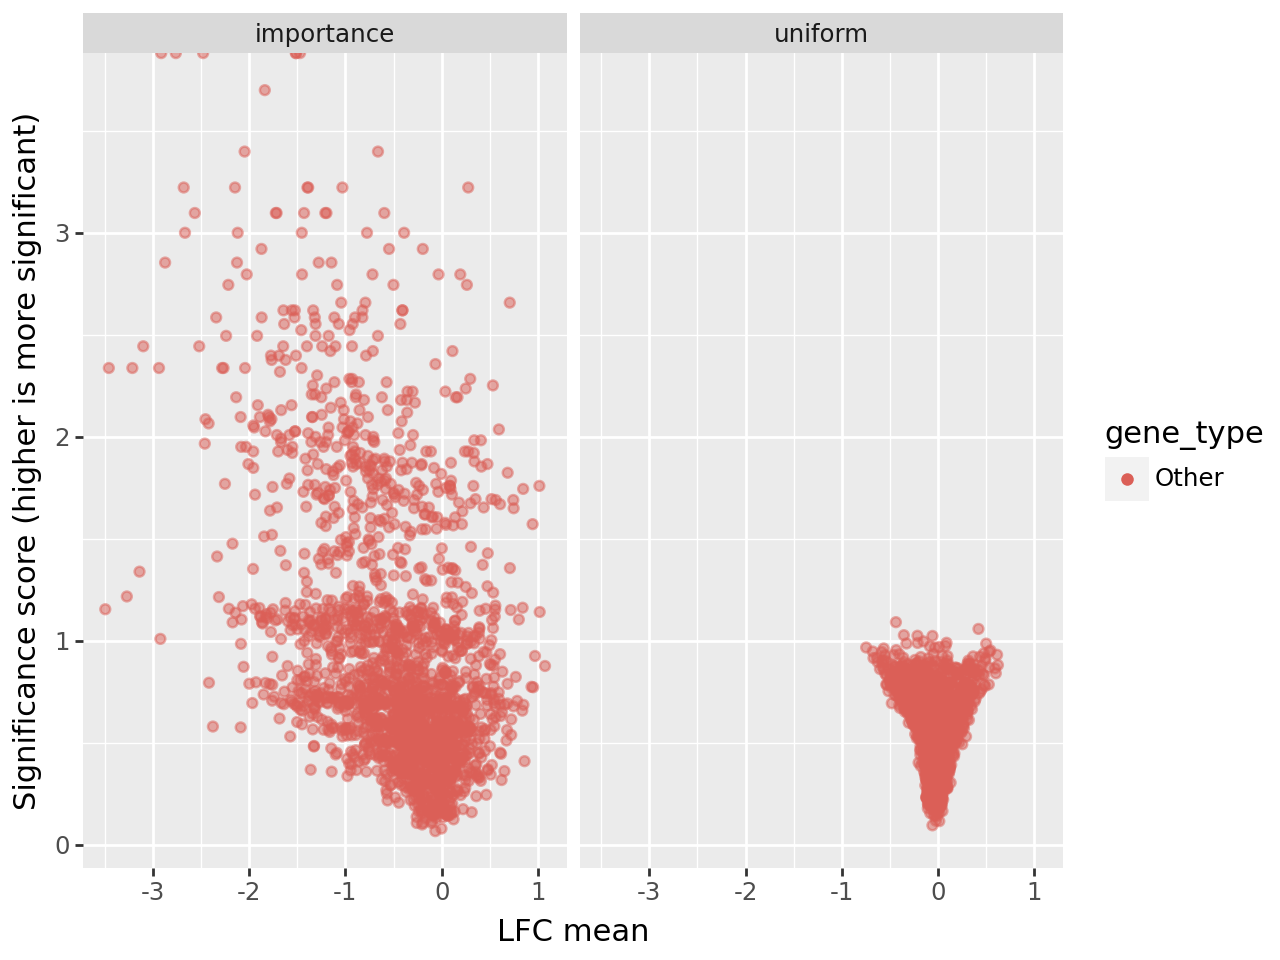

In [80]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)


In [81]:
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/3 [00:00<?, ?it/s]

In [82]:
cell_types = (
    adata_non_immune.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [85]:
cell_types

,n_cells,associated_test
cell_type,,
None,23339,None vs Rest
cluster1_T2,2872,cluster1_T2 vs Rest
cluster1_Ta,1653,cluster1_Ta vs Rest


In [112]:
marker_genes_full = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False)
    ))

/tmp/ipykernel_1043649/624023384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [115]:
marker_genes_full.to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_DEG.xlsx')

In [102]:
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:10]
    ))

/tmp/ipykernel_1043649/600422265.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [103]:
marker_genes

Gene  proba_de  proba_not_de  bayes_factor  \
comparison                                                                   
None vs Rest        111       SPINK1    0.9526        0.0474      3.000573   
                    64        IGFBP5    0.9572        0.0428      3.107474   
                    220       IGFBP2    0.9444        0.0556      2.832366   
                    302         TESC    0.9400        0.0600      2.751535   
                    210        DUSP2    0.9452        0.0548      2.847706   
                    286       SPOCD1    0.9410        0.0590      2.769406   
                    85         GDF15    0.9550        0.0450      3.055049   
                    754         MEST    0.9118        0.0882      2.335814   
                    569     C10orf99    0.9244        0.0756      2.503688   
                    118        ADH1C    0.9506        0.0494      2.957143   
cluster1_T2 vs Rest 2003      S100A8    0.9882        0.0118      4.427785   
                    2027        TCHH    0.9828        0.0172      4.045496   
                    2005       LYNX1    0.9874        0.0126      4.361378   
                    2016      S100A9    0.9842        0.0158      4.131819   
                    2014    SERPINB4    0.9844        0.0156      4.144761   
                    2002      KRTDAP    0.9888        0.0112      4.480577   
                    2029    SERPINB3    0.9820        0.0180      3.999219   
                    2037        CD36    0.9810        0.0190      3.944133   
                    2123  AC018816.3    0.9736        0.0264      3.607636   
                    2001       MMP12    0.9904        0.0096      4.636345   
cluster1_Ta vs Rest 4001       UPK1A    0.9706        0.0294      3.496919   
                    4011     EPB41L3    0.9616        0.0384      3.220541   
                    4010       PHGR1    0.9616        0.0384      3.220541   
                    4023      SPOCK1    0.9572        0.0428      3.107474   
                    4205        SDC2    0.9368        0.0632      2.696165   
                    4034       FABP4    0.9532        0.0468      3.013941   
                    4021    APOBEC3A    0.9572        0.0428      3.107474   
                    4834      IGFBP2    0.8958        0.1042      2.151405   
                    4149      TRIM31    0.9404        0.0596      2.758650   
                    4003        UPK2    0.9676        0.0324      3.396660   

                            scale1    scale2  pseudocounts  delta   lfc_mean  \
comparison                                                                     
None vs Rest        111   0.008965  0.003320           0.0   0.25   4.872784   
                    64    0.000671  0.000325           0.0   0.25   4.164415   
                    220   0.001023  0.000617           0.0   0.25   3.839029   
                    302   0.000477  0.000169           0.0   0.25   3.802972   
                    210   0.001429  0.000405           0.0   0.25   3.500047   
                    286   0.000221  0.000136           0.0   0.25   3.382589   
                    85    0.002572  0.000967           0.0   0.25   3.236443   
                    754   0.000054  0.000015           0.0   0.25   3.169221   
                    569   0.000236  0.000124           0.0   0.25   3.068669   
                    118   0.000038  0.000009           0.0   0.25   2.905634   
cluster1_T2 vs Rest 2003  0.018520  0.001026           0.0   0.25  11.116735   
                    2027  0.000125  0.000010           0.0   0.25   8.430903   
                    2005  0.000520  0.000039           0.0   0.25   7.749890   
                    2016  0.019399  0.001553           0.0   0.25   7.666663   
                    2014  0.000427  0.000033           0.0   0.25   7.538958   
                    2002  0.000275  0.000017           0.0   0.25   7.087183   
                    2029  0.000485  0.000053           0.0   0.25   6.790660   
               

In [99]:
adata_log = adata_non_immune[adata_non_immune.obs.cell_type.isin(cell_types.index.values)].copy()


In [105]:
adata_log

AnnData object with n_obs × n_vars = 27864 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Status', 'Stage', 'cell_type', '_scvi_raw_norm_scaling'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_B

In [104]:
adata_log = adata_log[adata_log.obs['cell_type'].notna()].copy()


In [97]:
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)

In [107]:
adata_log.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,Status,Stage,cell_type,_scvi_raw_norm_scaling
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5,Ta,Ta,None,0.696913
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2,Ta,Ta,None,1.774308
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2,Ta,Ta,None,0.849762
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4,Ta,Ta,None,1.432460
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1,Ta,Ta,cluster1_Ta,1.034126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0,Ta,Ta,None,3.114295
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0,Ta,Ta,None,4.514673
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2,Ta,Ta,None,0.958497
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1,Ta,Ta,cluster1_Ta,1.938736


In [110]:
marker_genes['Gene']

comparison               
None vs Rest         111         SPINK1
                     64          IGFBP5
                     220         IGFBP2
                     302           TESC
                     210          DUSP2
                     286         SPOCD1
                     85           GDF15
                     754           MEST
                     569       C10orf99
                     118          ADH1C
cluster1_T2 vs Rest  2003        S100A8
                     2027          TCHH
                     2005         LYNX1
                     2016        S100A9
                     2014      SERPINB4
                     2002        KRTDAP
                     2029      SERPINB3
                     2037          CD36
                     2123    AC018816.3
                     2001         MMP12
cluster1_Ta vs Rest  4001         UPK1A
                     4011       EPB41L3
                     4010         PHGR1
                     4023        SPOCK1
              

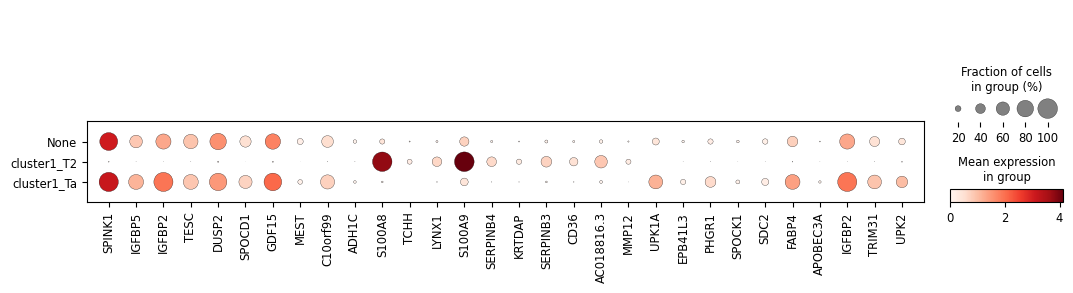

In [111]:
sc.pl.dotplot(adata_log, marker_genes['Gene'],groupby='cell_type')